This notebooks is hosted on [codeberg](https://codeberg.org/cknoll/kram/src/branch/main/python-stuff/mastodon-discourse-visualization).

It depends on some packages and files which are not part of this repo:

- https://mastodonpy.readthedocs.io/en/stable/index.html#
- https://networkx.org/documentation/stable/reference/drawing.html
- https://github.com/twosigma/nxv
- https://codeberg.org/cknoll/cachewrapper (optional)


Install these dependencies by 
```
pip install mastodonpy networkx nxv

```

In [1]:
import time
print(time.ctime())
# https://github.com/cknoll/ipydex (optional)
%load_ext ipydex.displaytools 

Fri Jan 14 17:08:44 2022


In [2]:
from mastodon import Mastodon  # https://mastodonpy.readthedocs.io/en/stable/index.html#
import networkx as nx  # https://networkx.org/documentation/stable/reference/drawing.html
import nxv  # https://github.com/twosigma/nxv
from matplotlib import pyplot as plt
try:
    import cachewrapper as cw # https://codeberg.org/cknoll/cachewrapper (optional)
except ImportError:
    cw = None
from IPython.display import SVG, display, HTML


masto_url = "https://social.tchncs.de"
cache_path = "cache.pcl"


# mc means "mastodon-client"
mc = Mastodon(
    access_token = 'pymastoclient_usercred.secret',
    api_base_url = masto_url,
)

# this is optional (to save api-calls)
if cw:
    mc = cw.CacheWrapper(mc)
    mc.load_cache(cache_path)

# id taken from url
root_id = "107611511992734130"
res = mc.status_context(root_id) ##:i
mc.save_cache(cache_path)

ancestors = res["ancestors"] ##:i
descendants = res["descendants"] ##:i

info(res) := "<class 'mastodon.Mastodon.AttribAccessDict'> with length: 2"

---

info(ancestors) := "<class 'list'> with length: 0"

---

info(descendants) := "<class 'list'> with length: 80"

---

In [3]:
# instantiate the default color_cycler from matlotlib
color_cycler = plt.rcParamsDefault['axes.prop_cycle']()
# next(color_cycler) -> {'color': '#2ca02c'} etc

In [4]:
author_color_map = {}

In [5]:
def get_author_color(data):
    aid = data["account"]["id"]
    color = author_color_map.get(aid)
    if color:
        return color
    else:
        # get new color from cycler, save it, return it
        color = next(color_cycler)["color"]
        author_color_map[aid] = color
        return color
    

In [6]:
class Node(object):
    def __init__(self, data: dict):
        self.id = str(data["id"])
        self.label = self.id
        self.data = data
        
        
        author = data["account"]["display_name"]
        N = 10
        if len(author) > N:
            author = f"{author[:N-2]}…"
        # label-trick: generate strings like r'{K12345}'
        # these can be substituted later -> two keys for linebreak
        self.repr_str = f"{author}:\n{{K{self.id}}}\n{{X{self.id}}}"
        
        self.style_dict = {
            "color": get_author_color(data),
            "fillcolor": get_author_color(data)+"20", # add low alpha-value for transparency
            "style": "filled",
            "shape": "circle",
            "fixedsize": True,
            "width": 0.7,
            "fontsize": 8,
            "penwidth": 2,

        }

    def __repr__(self):
        
        return self.repr_str

In [7]:
G = nx.DiGraph()

root_node = Node(data=mc.status(root_id))
id_map = {root_id: root_node}

G.add_node(root_node)
parent = root_node

for obj_data in descendants:
    node = Node(obj_data)
    id_map[node.id] = node
    
    parent = id_map[str(node.data["in_reply_to_id"])]
    G.add_node(node, color="red", shape="pentagon")
    G.add_edge(parent, node)
    
    


In [8]:
# see https://nxv.readthedocs.io/en/latest/reference.html#styling
style = nxv.Style(
    graph={"rankdir": "TB"},
    node=lambda u, d: u.style_dict,
        # u is a node and d is its attribute dict (which is ignored here)
    edge=lambda u, v, d: {"style": "solid", "arrowType": "normal", "label": ""},
)



svg_data = nxv.render(G, style, format="svg")

entity_links = []

for node in G.nodes.keys():
    date = node.data["created_at"]
    str1 = f'<a href="{node.data["url"]}">{date.strftime("%Y-%m-%d")}</a>'
    str2 = f'<a href="{node.data["url"]}">{date.strftime("%H:%M:%S")}</a>'
    entity_links.append((f"K{node.id}", str1))
    entity_links.append((f"X{node.id}", str2))

# insert links to wiki data urls
svg_data = svg_data.decode("utf8").format(**dict(entity_links)).encode("utf8")

svg_fname = f"toot-analysis-{root_id}.svg"

with open(svg_fname, "wb") as svgfile:
    svgfile.write(svg_data)

#display(SVG(svg_data))

display(HTML(f"<a href='{svg_fname}'>{svg_fname}</a>"))


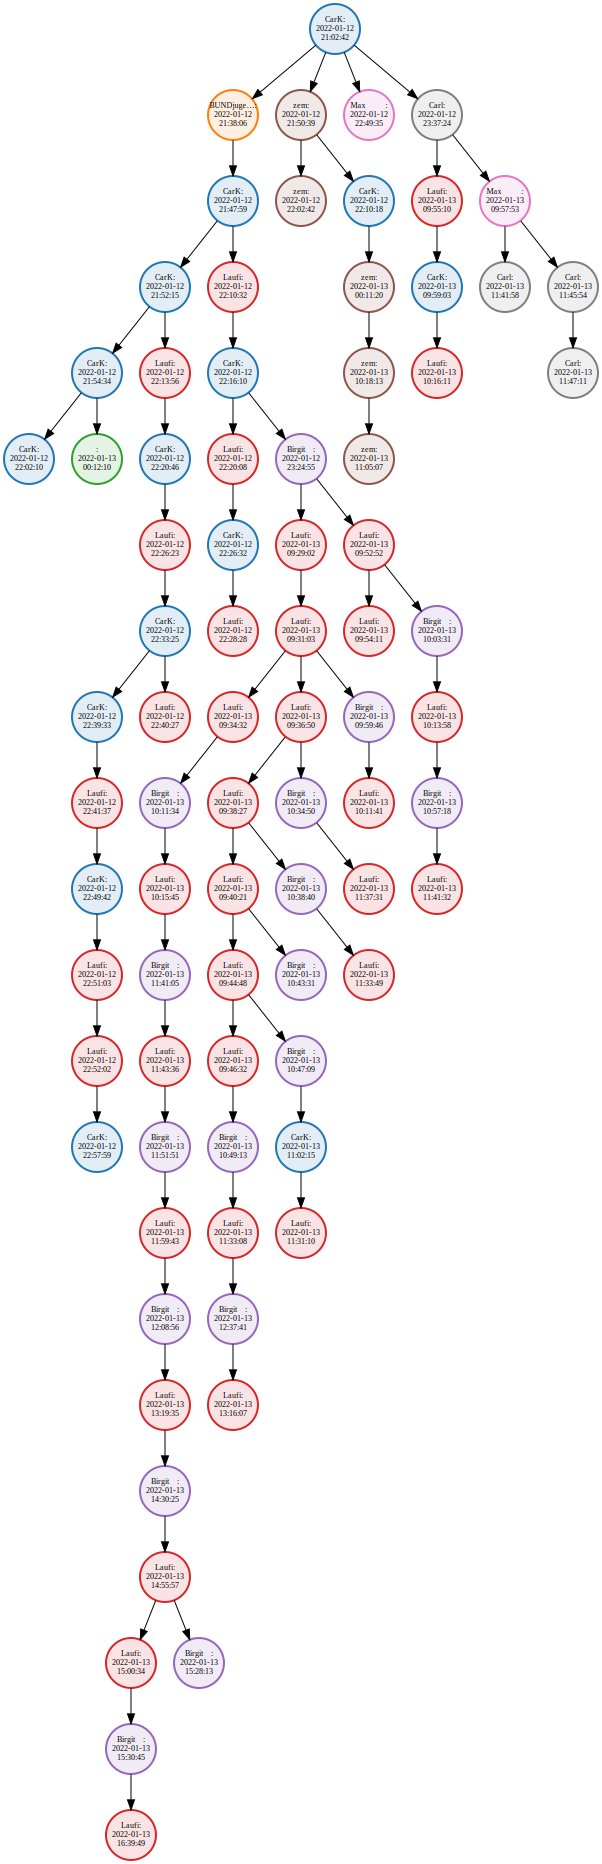

In [9]:
# display(HTML(f"<img src='{svg_fname}'>")) # this is prone to unexpected behavior due to caching
display(SVG(svg_data))
# click in the gray area below `In [..]` to disable/enable scrolling